# LSTM Travel Time + Speed Prediction - Cent.1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
traffic = pd.read_csv('../db.csv', parse_dates = ["timeStamp"])
traffic.head(10)

,currentSpeed,freeFlowSpeed,currentTravelTime,freeFlowTravelTime,roadName,roadClosure,timeStamp
0,64,64,21,21,N103.1,False,2021-04-26 18:11:34
1,34,43,49,39,N103.0,False,2021-04-27 14:53:37
2,64,64,21,21,N103.1,False,2021-04-27 14:53:49
3,51,51,37,37,N103.2,False,2021-04-27 14:54:00
4,74,74,21,21,N101.0,False,2021-04-27 14:54:12
5,33,43,51,39,N103.0,False,2021-04-27 14:57:10
6,64,64,21,21,N103.1,False,2021-04-27 14:57:22
7,39,50,49,38,N103.2,False,2021-04-27 14:57:33
8,74,74,21,21,N101.0,False,2021-04-27 14:57:45
9,52,67,28,21,N101.1,False,2021-04-27 14:57:57


In [3]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294475 entries, 0 to 294474
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   currentSpeed        294475 non-null  int64         
 1   freeFlowSpeed       294475 non-null  int64         
 2   currentTravelTime   294475 non-null  int64         
 3   freeFlowTravelTime  294475 non-null  int64         
 4   roadName            294475 non-null  object        
 5   roadClosure         294475 non-null  bool          
 6   timeStamp           294475 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(1)
memory usage: 13.8+ MB


In [4]:
print(traffic['roadName'].unique())

['N103.1' 'N103.0' 'N103.2' 'N101.0' 'N101.1' 'N101.2' 'N101.3' 'N101.4'
 'N101.5' 'Cent.0' 'Cent.1' 'Cent.2' 'Cent.3' 'Cent.4']


### Filter Roads

In [5]:
traffic = traffic[(traffic['roadName'] == 'Cent.1')]

### Drop unwanted columns 

In [6]:
traffic = traffic.drop(columns = ['roadClosure', 'freeFlowTravelTime', 'freeFlowSpeed', 'roadName'])

### Remove incomplete days

In [7]:
tfc = traffic[(traffic['timeStamp'].dt.day != 26) 
                        & (traffic['timeStamp'].dt.day != 27) 
                        & (traffic['timeStamp'].dt.day != 3)]

### Treat Date and Time

In [8]:
tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")

<ipython-input-8-7e39a034e481>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfc['timeStamp'] = pd.to_datetime(tfc['timeStamp']).dt.strftime("%Y%m%d%H")


In [9]:
tfc

,currentSpeed,currentTravelTime,timeStamp
6386,31,15,2021042800
6400,31,15,2021042800
6414,31,15,2021042800
6428,31,15,2021042800
6442,31,15,2021042800
...,...,...,...
294411,11,61,2021051509
294425,11,61,2021051509
294439,11,61,2021051509
294453,11,61,2021051509


In [10]:
traffic_by_date = tfc.groupby(['timeStamp'])
traffic_by_date_mean = traffic_by_date.mean()
traffic_by_date_mean

,currentSpeed,currentTravelTime
timeStamp,,
2021042800,31.000000,15.000000
2021042801,31.000000,15.000000
2021042802,31.000000,15.000000
2021042803,31.000000,15.000000
2021042804,31.000000,15.000000
...,...,...
2021051505,11.000000,61.000000
2021051506,11.000000,61.000000
2021051507,11.000000,61.000000


### Normalize Data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (-1, 1))

normalized_Time = traffic_by_date_mean
normalized_Speed = traffic_by_date_mean

normalized_Time[['currentTravelTime']] = scaler.fit_transform(traffic_by_date_mean[['currentTravelTime']])
normalized_Time = normalized_Time.drop(columns = ['currentSpeed'])
normalized_Time

normalized_Speed[['currentSpeed']] = scaler.fit_transform(traffic_by_date_mean[['currentSpeed']])
normalized_Speed = normalized_Speed.drop(columns = ['currentTravelTime'])
normalized_Speed

,currentSpeed
timeStamp,
2021042800,0.919192
2021042801,0.919192
2021042802,0.919192
2021042803,0.919192
2021042804,0.919192
...,...
2021051505,-0.696970
2021051506,-0.696970
2021051507,-0.696970


In [12]:
# 24 hours that make the sequence
TIMESTEPS = 24

# number of features used by the model (using conf. cases to predict conf. cases)
FEATURES = len(normalized_Time.columns)

# number of hours to forecast - we will forecast the next 12 hours
MULTISTEPS = 12

# time series cross validator
CV_SPLITS = 5

EPOCHS = 300

# 24 hours (1 day)
BATCH_SIZE = 24

In [13]:
# split data into training and validation sets
def split_data(training, percentage = 15):
    train_idx = np.arange(0, int(len(training) * (100 - percentage) / 100))
    val_idx = np.arange(int(len(training) * (100 - percentage) / 100 + 1), len(training))
    
    return train_idx, val_idx

# LSTM - Time

In [14]:
# Preparing the dataset for the LSTM
def to_supervised(df, timesteps, features = 1):

    data = df.values
    x, y = [], []
    
    # iterate over the training set to create x and y
    dataset_size = len(data)
    
    for curr_pos in range(dataset_size):
        # end of the input sequence is the current position + the number 
        # of timesteps of the input sequence
        input_index = curr_pos + timesteps
        
        # end of the labels correspond to the end of the input sequence + 1
        label_index = input_index + 1
        
        # if we have enough data for this sequence 
        if label_index < dataset_size:
            x.append(data[curr_pos:input_index, :])
            y.append(data[input_index:label_index, 0])
        
    # using np.float32 for GPU performance
    return np.array(x).astype('float32'), np.array(y).astype('float32')


def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))
    

def build_model(timesteps, features, name, h_neurons = 128):
    
    model = tf.keras.models.Sequential(name = name)
    
    model.add(LSTM(h_neurons, return_sequences = True,
                   input_shape = (timesteps, features), 
                   activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(LSTM(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(h_neurons, activation = 'tanh'))
    model.add(Dropout(0.2))
    
    model.add(Dense(features, activation = 'tanh'))
    
    return model


# Compiling and fit the model
def compile_and_fit(model, x, y, epochs, batch_size, cv_splits):
    callback = []
    
    callback.append(EarlyStopping(monitor = 'val_loss', min_delta = 0, 
                                  patience = 20, verbose = 0, 
                                  mode = 'auto', restore_best_weights = True))
    
    callback.append(ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                                      patience = 20, verbose = 0,
                                      mode = 'auto', cooldown = 0, 
                                      min_lr = 0.0001))
    
    # compile
    model.compile(loss = rmse, 
                  optimizer = 'Adagrad', 
                  metrics = ['mae', rmse])    
    
    # fit
    hist_list = []
    loss_list = []
    
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits = cv_splits)
    
    for train_index, test_index in tscv.split(x):
        # further split into training and validation sets
        train_idx, val_idx = split_data(train_index, percentage = 15)
        
        x_train, y_train = x[train_idx], y[train_idx]
        x_val, y_val = x[val_idx], y[val_idx]
        #x_test, y_test = x[test_index], y[test_index]
        
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                            epochs = epochs, batch_size = batch_size, 
                            shuffle = False, callbacks = callback)
        
        plot_learning_curves(history, model_name = model.get_config()['name'])
    
    return model, hist_list, loss_list


# Recursive Multi-step Forecast
def forecast(model, df, scaler, timesteps, multisteps, features, batch_size):
    # getting the last sequence of known value
    input_seq = df[-timesteps:].values
    inp = input_seq
    forecasts = []
    
    # multisteps tells us how many iterations we want to perform, i.e., how many days
    # we want to predict
    for step in range(1, multisteps + 1):
     
        inp = inp.reshape(1, timesteps, features)
        
        yhat = model.predict(inp)
        
        print('yhat', yhat[0][features-1])
        
        yhat_inversed = scaler.inverse_transform(yhat)
        
        print('Transformed yhat', yhat_inversed[0][features-1])
        
        forecasts.append(round(yhat_inversed[0][features-1], 1))
    
        inp = np.append(inp[0], yhat[0])
        
        inp = inp[-timesteps*features:]
        
    return forecasts


def plot_prediction(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Travel Time For The Next 12H')
    plt.ylabel('Current Travel Time (min)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()

def plot_prediction_Speed(data, forecasts, scaler):
    
    d = data.values[-24:, -1]
    d = scaler.inverse_transform([d])[0]
    
    print('Real data:', d)
    print('Forecasting values:', forecasts)
    
    f = []; f.append(round(d[-1])); f.extend(forecasts)
    
    plt.figure(figsize = (8, 6))
    plt.plot(range(len(d)), d, color = 'mediumpurple', label = 'Real', linewidth=3)
    plt.plot(range(len(d) - 1, len(d) + len(f) - 1),
             f, color = 'purple', label = 'predicted', linewidth=3)
    plt.title('Current Speed For The Next 12H')
    plt.ylabel('Current Speed (KM/H)')
    plt.xlabel('Hours')
    plt.legend()
    plt.show()



def plot_learning_curves(history, model_name):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['rmse'], color = 'mediumpurple',linewidth=3)
    plt.plot(history.history['val_rmse'], color = 'purple',linewidth=3)
    plt.title('Model ({}) rmse'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color = 'mediumpurple', linewidth=3)
    plt.plot(history.history['val_loss'], color = 'purple', linewidth=3)
    plt.title('Model ({}) loss'.format(model_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

In [15]:
# our supervised problem
x, y = to_supervised(normalized_Time, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 12s 1s/step - loss: 0.2847 - mae: 0.2303 - rmse: 0.2676 - val_loss: 0.1111 - val_mae: 0.1111 - val_rmse: 0.1111
Epoch 2/300
3/3 [==============================] - 0s 113ms/step - loss: 0.2550 - mae: 0.1851 - rmse: 0.2356 - val_loss: 0.0701 - val_mae: 0.0701 - val_rmse: 0.0701
Epoch 3/300
3/3 [==============================] - 0s 96ms/step - loss: 0.2171 - mae: 0.1409 - rmse: 0.1988 - val_loss: 0.0375 - val_mae: 0.0375 - val_rmse: 0.0375
Epoch 4/300
3/3 [==============================] - 0s 97ms/step - loss: 0.1986 - mae: 0.1106 - rmse: 0.1764 - val_loss: 0.0127 - val_mae: 0.0127 - val_rmse: 0.0127
Epoch 5/300
3/3 [==============================] - 0s 120ms/step - loss: 0.1911 - mae: 0.0990 - rmse: 0.1704 - val_loss: 0.0080 - val_mae: 0.0080 - val_rmse: 0.0080
Epoch 6/300
3/3 [==============================] - 0s 88ms/step - loss: 0.1846 - mae: 0.0927 - rmse: 0.1655 - val_loss: 0.0028 - val_mae: 0.0028 - val_rmse: 0.0028
Epoch 7/300
3/3

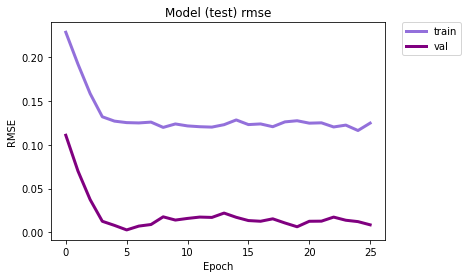

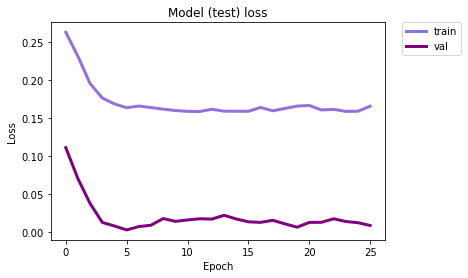

Epoch 1/300
5/5 [==============================] - 0s 103ms/step - loss: 0.1127 - mae: 0.0559 - rmse: 0.1170 - val_loss: 0.0628 - val_mae: 0.0259 - val_rmse: 0.0628
Epoch 2/300
5/5 [==============================] - 0s 92ms/step - loss: 0.1151 - mae: 0.0573 - rmse: 0.1201 - val_loss: 0.0627 - val_mae: 0.0265 - val_rmse: 0.0627
Epoch 3/300
5/5 [==============================] - 0s 78ms/step - loss: 0.1135 - mae: 0.0570 - rmse: 0.1169 - val_loss: 0.0625 - val_mae: 0.0272 - val_rmse: 0.0625
Epoch 4/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1077 - mae: 0.0532 - rmse: 0.1142 - val_loss: 0.0624 - val_mae: 0.0276 - val_rmse: 0.0624
Epoch 5/300
5/5 [==============================] - 0s 83ms/step - loss: 0.1126 - mae: 0.0559 - rmse: 0.1156 - val_loss: 0.0623 - val_mae: 0.0282 - val_rmse: 0.0623
Epoch 6/300
5/5 [==============================] - 0s 89ms/step - loss: 0.1100 - mae: 0.0542 - rmse: 0.1152 - val_loss: 0.0621 - val_mae: 0.0288 - val_rmse: 0.0621
Epoch 7/300
5/5

5/5 [==============================] - 0s 99ms/step - loss: 0.1103 - mae: 0.0569 - rmse: 0.1144 - val_loss: 0.0614 - val_mae: 0.0345 - val_rmse: 0.0614
Epoch 51/300
5/5 [==============================] - 0s 94ms/step - loss: 0.1126 - mae: 0.0598 - rmse: 0.1179 - val_loss: 0.0614 - val_mae: 0.0345 - val_rmse: 0.0614
Epoch 52/300
5/5 [==============================] - 0s 89ms/step - loss: 0.1101 - mae: 0.0574 - rmse: 0.1143 - val_loss: 0.0614 - val_mae: 0.0346 - val_rmse: 0.0614
Epoch 53/300
5/5 [==============================] - 0s 91ms/step - loss: 0.1090 - mae: 0.0583 - rmse: 0.1128 - val_loss: 0.0614 - val_mae: 0.0345 - val_rmse: 0.0614
Epoch 54/300
5/5 [==============================] - 0s 80ms/step - loss: 0.1147 - mae: 0.0597 - rmse: 0.1186 - val_loss: 0.0614 - val_mae: 0.0346 - val_rmse: 0.0614
Epoch 55/300
5/5 [==============================] - 0s 93ms/step - loss: 0.1167 - mae: 0.0594 - rmse: 0.1203 - val_loss: 0.0614 - val_mae: 0.0346 - val_rmse: 0.0614
Epoch 56/300
5/5 [=====

Epoch 100/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1130 - mae: 0.0594 - rmse: 0.1169 - val_loss: 0.0614 - val_mae: 0.0352 - val_rmse: 0.0614
Epoch 101/300
5/5 [==============================] - 0s 92ms/step - loss: 0.1133 - mae: 0.0597 - rmse: 0.1172 - val_loss: 0.0614 - val_mae: 0.0352 - val_rmse: 0.0614
Epoch 102/300
5/5 [==============================] - 0s 87ms/step - loss: 0.1130 - mae: 0.0594 - rmse: 0.1157 - val_loss: 0.0614 - val_mae: 0.0352 - val_rmse: 0.0614
Epoch 103/300
5/5 [==============================] - 1s 114ms/step - loss: 0.1081 - mae: 0.0592 - rmse: 0.1121 - val_loss: 0.0614 - val_mae: 0.0352 - val_rmse: 0.0614
Epoch 104/300
5/5 [==============================] - 0s 96ms/step - loss: 0.1129 - mae: 0.0585 - rmse: 0.1178 - val_loss: 0.0614 - val_mae: 0.0352 - val_rmse: 0.0614
Epoch 105/300
5/5 [==============================] - 0s 93ms/step - loss: 0.1099 - mae: 0.0577 - rmse: 0.1130 - val_loss: 0.0614 - val_mae: 0.0353 - val_rmse: 0.0614
Epo

5/5 [==============================] - 1s 120ms/step - loss: 0.1113 - mae: 0.0555 - rmse: 0.1163 - val_loss: 0.0614 - val_mae: 0.0356 - val_rmse: 0.0614
Epoch 150/300
5/5 [==============================] - 1s 115ms/step - loss: 0.1112 - mae: 0.0587 - rmse: 0.1145 - val_loss: 0.0614 - val_mae: 0.0356 - val_rmse: 0.0614
Epoch 151/300
5/5 [==============================] - 1s 183ms/step - loss: 0.1127 - mae: 0.0601 - rmse: 0.1167 - val_loss: 0.0614 - val_mae: 0.0355 - val_rmse: 0.0614
Epoch 152/300
5/5 [==============================] - 1s 121ms/step - loss: 0.1132 - mae: 0.0599 - rmse: 0.1165 - val_loss: 0.0614 - val_mae: 0.0355 - val_rmse: 0.0614
Epoch 153/300
5/5 [==============================] - 1s 109ms/step - loss: 0.1114 - mae: 0.0595 - rmse: 0.1126 - val_loss: 0.0614 - val_mae: 0.0354 - val_rmse: 0.0614
Epoch 154/300
5/5 [==============================] - 0s 103ms/step - loss: 0.1082 - mae: 0.0573 - rmse: 0.1135 - val_loss: 0.0614 - val_mae: 0.0353 - val_rmse: 0.0614
Epoch 155/30

5/5 [==============================] - 0s 107ms/step - loss: 0.1129 - mae: 0.0597 - rmse: 0.1173 - val_loss: 0.0613 - val_mae: 0.0354 - val_rmse: 0.0613
Epoch 199/300
5/5 [==============================] - 1s 118ms/step - loss: 0.1142 - mae: 0.0598 - rmse: 0.1180 - val_loss: 0.0613 - val_mae: 0.0353 - val_rmse: 0.0613
Epoch 200/300
5/5 [==============================] - 0s 98ms/step - loss: 0.1128 - mae: 0.0578 - rmse: 0.1199 - val_loss: 0.0613 - val_mae: 0.0353 - val_rmse: 0.0613
Epoch 201/300
5/5 [==============================] - 0s 76ms/step - loss: 0.1140 - mae: 0.0599 - rmse: 0.1172 - val_loss: 0.0613 - val_mae: 0.0353 - val_rmse: 0.0613
Epoch 202/300
5/5 [==============================] - 1s 125ms/step - loss: 0.1106 - mae: 0.0575 - rmse: 0.1149 - val_loss: 0.0613 - val_mae: 0.0353 - val_rmse: 0.0613
Epoch 203/300
5/5 [==============================] - 1s 111ms/step - loss: 0.1088 - mae: 0.0581 - rmse: 0.1126 - val_loss: 0.0613 - val_mae: 0.0353 - val_rmse: 0.0613
Epoch 204/300


5/5 [==============================] - 0s 61ms/step - loss: 0.1061 - mae: 0.0571 - rmse: 0.1110 - val_loss: 0.0613 - val_mae: 0.0349 - val_rmse: 0.0613
Epoch 248/300
5/5 [==============================] - 0s 59ms/step - loss: 0.1136 - mae: 0.0618 - rmse: 0.1174 - val_loss: 0.0613 - val_mae: 0.0349 - val_rmse: 0.0613
Epoch 249/300
5/5 [==============================] - 0s 59ms/step - loss: 0.1098 - mae: 0.0561 - rmse: 0.1141 - val_loss: 0.0613 - val_mae: 0.0349 - val_rmse: 0.0613
Epoch 250/300
5/5 [==============================] - 0s 62ms/step - loss: 0.1067 - mae: 0.0537 - rmse: 0.1101 - val_loss: 0.0613 - val_mae: 0.0350 - val_rmse: 0.0613
Epoch 251/300
5/5 [==============================] - 0s 58ms/step - loss: 0.1119 - mae: 0.0574 - rmse: 0.1177 - val_loss: 0.0613 - val_mae: 0.0350 - val_rmse: 0.0613
Epoch 252/300
5/5 [==============================] - 1s 139ms/step - loss: 0.1127 - mae: 0.0580 - rmse: 0.1173 - val_loss: 0.0613 - val_mae: 0.0351 - val_rmse: 0.0613
Epoch 253/300
5/5

5/5 [==============================] - 0s 99ms/step - loss: 0.1098 - mae: 0.0580 - rmse: 0.1146 - val_loss: 0.0613 - val_mae: 0.0347 - val_rmse: 0.0613
Epoch 297/300
5/5 [==============================] - 1s 121ms/step - loss: 0.1082 - mae: 0.0560 - rmse: 0.1119 - val_loss: 0.0613 - val_mae: 0.0348 - val_rmse: 0.0613
Epoch 298/300
5/5 [==============================] - 1s 118ms/step - loss: 0.1121 - mae: 0.0588 - rmse: 0.1156 - val_loss: 0.0613 - val_mae: 0.0347 - val_rmse: 0.0613
Epoch 299/300
5/5 [==============================] - 0s 85ms/step - loss: 0.1086 - mae: 0.0543 - rmse: 0.1120 - val_loss: 0.0613 - val_mae: 0.0347 - val_rmse: 0.0613
Epoch 300/300
5/5 [==============================] - 0s 90ms/step - loss: 0.1102 - mae: 0.0592 - rmse: 0.1126 - val_loss: 0.0613 - val_mae: 0.0346 - val_rmse: 0.0613
dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


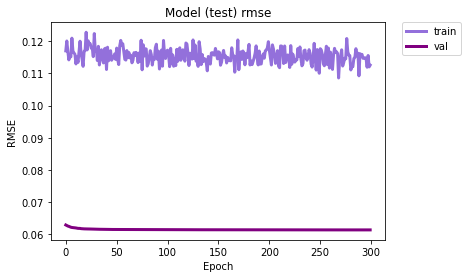

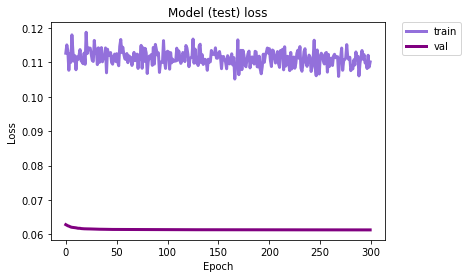

Epoch 1/300
7/7 [==============================] - 1s 153ms/step - loss: 0.1116 - mae: 0.0597 - rmse: 0.1370 - val_loss: 0.1838 - val_mae: 0.0933 - val_rmse: 0.1123
Epoch 2/300
7/7 [==============================] - 0s 71ms/step - loss: 0.1112 - mae: 0.0596 - rmse: 0.1361 - val_loss: 0.1837 - val_mae: 0.0934 - val_rmse: 0.1124
Epoch 3/300
7/7 [==============================] - 1s 120ms/step - loss: 0.1127 - mae: 0.0611 - rmse: 0.1367 - val_loss: 0.1837 - val_mae: 0.0934 - val_rmse: 0.1124
Epoch 4/300
7/7 [==============================] - 1s 82ms/step - loss: 0.1136 - mae: 0.0619 - rmse: 0.1386 - val_loss: 0.1837 - val_mae: 0.0935 - val_rmse: 0.1125
Epoch 5/300
7/7 [==============================] - 1s 99ms/step - loss: 0.1146 - mae: 0.0621 - rmse: 0.1409 - val_loss: 0.1837 - val_mae: 0.0935 - val_rmse: 0.1125
Epoch 6/300
7/7 [==============================] - 1s 101ms/step - loss: 0.1121 - mae: 0.0591 - rmse: 0.1377 - val_loss: 0.1836 - val_mae: 0.0936 - val_rmse: 0.1125
Epoch 7/300
7

Epoch 51/300
7/7 [==============================] - 1s 77ms/step - loss: 0.1143 - mae: 0.0620 - rmse: 0.1389 - val_loss: 0.1828 - val_mae: 0.0949 - val_rmse: 0.1133
Epoch 52/300
7/7 [==============================] - 1s 100ms/step - loss: 0.1143 - mae: 0.0624 - rmse: 0.1396 - val_loss: 0.1828 - val_mae: 0.0950 - val_rmse: 0.1134
Epoch 53/300
7/7 [==============================] - 1s 84ms/step - loss: 0.1097 - mae: 0.0596 - rmse: 0.1356 - val_loss: 0.1828 - val_mae: 0.0950 - val_rmse: 0.1134
Epoch 54/300
7/7 [==============================] - 1s 92ms/step - loss: 0.1192 - mae: 0.0650 - rmse: 0.1438 - val_loss: 0.1828 - val_mae: 0.0950 - val_rmse: 0.1134
Epoch 55/300
7/7 [==============================] - 0s 50ms/step - loss: 0.1138 - mae: 0.0635 - rmse: 0.1396 - val_loss: 0.1828 - val_mae: 0.0950 - val_rmse: 0.1134
Epoch 56/300
7/7 [==============================] - 0s 46ms/step - loss: 0.1148 - mae: 0.0632 - rmse: 0.1381 - val_loss: 0.1828 - val_mae: 0.0950 - val_rmse: 0.1134
Epoch 57/

7/7 [==============================] - 0s 64ms/step - loss: 0.1145 - mae: 0.0653 - rmse: 0.1398 - val_loss: 0.1825 - val_mae: 0.0953 - val_rmse: 0.1134
Epoch 101/300
7/7 [==============================] - 0s 60ms/step - loss: 0.1141 - mae: 0.0638 - rmse: 0.1385 - val_loss: 0.1825 - val_mae: 0.0953 - val_rmse: 0.1134
Epoch 102/300
7/7 [==============================] - 0s 62ms/step - loss: 0.1132 - mae: 0.0633 - rmse: 0.1388 - val_loss: 0.1825 - val_mae: 0.0953 - val_rmse: 0.1134
Epoch 103/300
7/7 [==============================] - 0s 65ms/step - loss: 0.1135 - mae: 0.0628 - rmse: 0.1390 - val_loss: 0.1825 - val_mae: 0.0953 - val_rmse: 0.1134
Epoch 104/300
7/7 [==============================] - 0s 59ms/step - loss: 0.1156 - mae: 0.0634 - rmse: 0.1406 - val_loss: 0.1825 - val_mae: 0.0953 - val_rmse: 0.1134
Epoch 105/300
7/7 [==============================] - 0s 66ms/step - loss: 0.1132 - mae: 0.0614 - rmse: 0.1377 - val_loss: 0.1825 - val_mae: 0.0954 - val_rmse: 0.1135
Epoch 106/300
7/7 

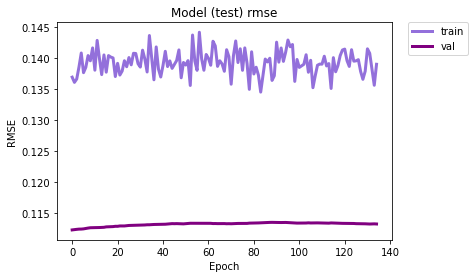

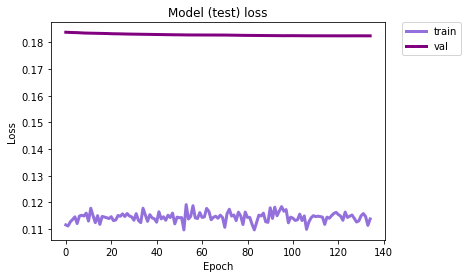

Epoch 1/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1406 - mae: 0.0798 - rmse: 0.1392 - val_loss: 0.0907 - val_mae: 0.0561 - val_rmse: 0.1312
Epoch 2/300
9/9 [==============================] - 1s 59ms/step - loss: 0.1403 - mae: 0.0810 - rmse: 0.1390 - val_loss: 0.0907 - val_mae: 0.0561 - val_rmse: 0.1312
Epoch 3/300
9/9 [==============================] - 1s 64ms/step - loss: 0.1410 - mae: 0.0788 - rmse: 0.1391 - val_loss: 0.0908 - val_mae: 0.0562 - val_rmse: 0.1313
Epoch 4/300
9/9 [==============================] - 1s 62ms/step - loss: 0.1418 - mae: 0.0795 - rmse: 0.1408 - val_loss: 0.0908 - val_mae: 0.0563 - val_rmse: 0.1313
Epoch 5/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1432 - mae: 0.0811 - rmse: 0.1411 - val_loss: 0.0909 - val_mae: 0.0564 - val_rmse: 0.1313
Epoch 6/300
9/9 [==============================] - 1s 63ms/step - loss: 0.1412 - mae: 0.0801 - rmse: 0.1397 - val_loss: 0.0909 - val_mae: 0.0564 - val_rmse: 0.1313
Epoch 7/300
9/9 

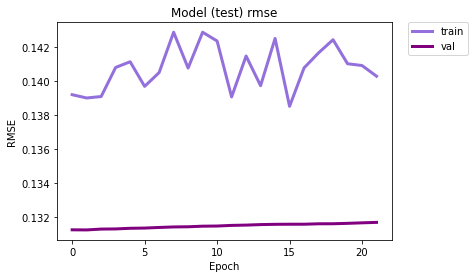

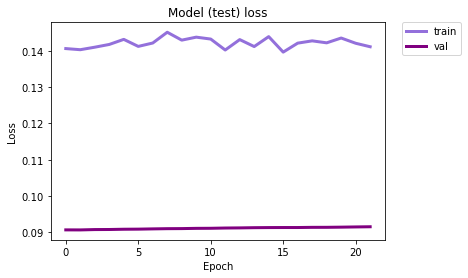

Epoch 1/300
11/11 [==============================] - 1s 57ms/step - loss: 0.1406 - mae: 0.0762 - rmse: 0.1400 - val_loss: 0.1228 - val_mae: 0.0582 - val_rmse: 0.1180
Epoch 2/300
11/11 [==============================] - 1s 57ms/step - loss: 0.1388 - mae: 0.0756 - rmse: 0.1392 - val_loss: 0.1228 - val_mae: 0.0584 - val_rmse: 0.1180
Epoch 3/300
11/11 [==============================] - 1s 56ms/step - loss: 0.1367 - mae: 0.0754 - rmse: 0.1359 - val_loss: 0.1228 - val_mae: 0.0586 - val_rmse: 0.1180
Epoch 4/300
11/11 [==============================] - 1s 60ms/step - loss: 0.1413 - mae: 0.0779 - rmse: 0.1421 - val_loss: 0.1228 - val_mae: 0.0587 - val_rmse: 0.1180
Epoch 5/300
11/11 [==============================] - 1s 63ms/step - loss: 0.1361 - mae: 0.0745 - rmse: 0.1366 - val_loss: 0.1228 - val_mae: 0.0588 - val_rmse: 0.1180
Epoch 6/300
11/11 [==============================] - 1s 61ms/step - loss: 0.1403 - mae: 0.0779 - rmse: 0.1400 - val_loss: 0.1228 - val_mae: 0.0590 - val_rmse: 0.1180
Epoc

11/11 [==============================] - 1s 61ms/step - loss: 0.1393 - mae: 0.0801 - rmse: 0.1391 - val_loss: 0.1226 - val_mae: 0.0617 - val_rmse: 0.1179
Epoch 51/300
11/11 [==============================] - 1s 58ms/step - loss: 0.1385 - mae: 0.0782 - rmse: 0.1381 - val_loss: 0.1226 - val_mae: 0.0617 - val_rmse: 0.1179
Epoch 52/300
11/11 [==============================] - 1s 60ms/step - loss: 0.1379 - mae: 0.0796 - rmse: 0.1382 - val_loss: 0.1226 - val_mae: 0.0617 - val_rmse: 0.1179
Epoch 53/300
11/11 [==============================] - 1s 65ms/step - loss: 0.1390 - mae: 0.0792 - rmse: 0.1388 - val_loss: 0.1226 - val_mae: 0.0617 - val_rmse: 0.1179
Epoch 54/300
11/11 [==============================] - 1s 63ms/step - loss: 0.1373 - mae: 0.0804 - rmse: 0.1378 - val_loss: 0.1226 - val_mae: 0.0617 - val_rmse: 0.1179
Epoch 55/300
11/11 [==============================] - 1s 60ms/step - loss: 0.1377 - mae: 0.0768 - rmse: 0.1367 - val_loss: 0.1226 - val_mae: 0.0618 - val_rmse: 0.1179
Epoch 56/30

11/11 [==============================] - 1s 64ms/step - loss: 0.1377 - mae: 0.0792 - rmse: 0.1384 - val_loss: 0.1226 - val_mae: 0.0627 - val_rmse: 0.1179
Epoch 100/300
11/11 [==============================] - 1s 81ms/step - loss: 0.1392 - mae: 0.0793 - rmse: 0.1394 - val_loss: 0.1226 - val_mae: 0.0627 - val_rmse: 0.1179
Epoch 101/300
11/11 [==============================] - 1s 76ms/step - loss: 0.1384 - mae: 0.0818 - rmse: 0.1385 - val_loss: 0.1226 - val_mae: 0.0626 - val_rmse: 0.1179
Epoch 102/300
11/11 [==============================] - 1s 74ms/step - loss: 0.1397 - mae: 0.0806 - rmse: 0.1394 - val_loss: 0.1226 - val_mae: 0.0626 - val_rmse: 0.1179
Epoch 103/300
11/11 [==============================] - 1s 78ms/step - loss: 0.1371 - mae: 0.0774 - rmse: 0.1365 - val_loss: 0.1226 - val_mae: 0.0627 - val_rmse: 0.1179
Epoch 104/300
11/11 [==============================] - 1s 86ms/step - loss: 0.1387 - mae: 0.0793 - rmse: 0.1383 - val_loss: 0.1226 - val_mae: 0.0627 - val_rmse: 0.1179
Epoch 

Epoch 148/300
11/11 [==============================] - 1s 50ms/step - loss: 0.1381 - mae: 0.0796 - rmse: 0.1370 - val_loss: 0.1226 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 149/300
11/11 [==============================] - 1s 59ms/step - loss: 0.1378 - mae: 0.0795 - rmse: 0.1383 - val_loss: 0.1226 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 150/300
11/11 [==============================] - 1s 46ms/step - loss: 0.1377 - mae: 0.0791 - rmse: 0.1376 - val_loss: 0.1226 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 151/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1384 - mae: 0.0793 - rmse: 0.1396 - val_loss: 0.1226 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 152/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1380 - mae: 0.0820 - rmse: 0.1386 - val_loss: 0.1226 - val_mae: 0.0627 - val_rmse: 0.1179
Epoch 153/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1368 - mae: 0.0779 - rmse: 0.1372 - val_loss: 0.1226 - val_mae: 0.0627 - val_rmse:

Epoch 197/300
11/11 [==============================] - 1s 86ms/step - loss: 0.1382 - mae: 0.0783 - rmse: 0.1375 - val_loss: 0.1225 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 198/300
11/11 [==============================] - 1s 70ms/step - loss: 0.1357 - mae: 0.0769 - rmse: 0.1361 - val_loss: 0.1225 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 199/300
11/11 [==============================] - 1s 59ms/step - loss: 0.1374 - mae: 0.0803 - rmse: 0.1371 - val_loss: 0.1225 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 200/300
11/11 [==============================] - 1s 66ms/step - loss: 0.1371 - mae: 0.0796 - rmse: 0.1368 - val_loss: 0.1225 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 201/300
11/11 [==============================] - 1s 93ms/step - loss: 0.1365 - mae: 0.0789 - rmse: 0.1370 - val_loss: 0.1225 - val_mae: 0.0628 - val_rmse: 0.1179
Epoch 202/300
11/11 [==============================] - 1s 55ms/step - loss: 0.1391 - mae: 0.0801 - rmse: 0.1391 - val_loss: 0.1225 - val_mae: 0.0627 - val_rmse:

Epoch 246/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1411 - mae: 0.0823 - rmse: 0.1416 - val_loss: 0.1225 - val_mae: 0.0628 - val_rmse: 0.1178
Epoch 247/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1395 - mae: 0.0783 - rmse: 0.1395 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 248/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1384 - mae: 0.0799 - rmse: 0.1387 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 249/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1371 - mae: 0.0795 - rmse: 0.1377 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 250/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1388 - mae: 0.0803 - rmse: 0.1384 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 251/300
11/11 [==============================] - 0s 45ms/step - loss: 0.1374 - mae: 0.0785 - rmse: 0.1373 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse:

Epoch 295/300
11/11 [==============================] - 0s 41ms/step - loss: 0.1388 - mae: 0.0808 - rmse: 0.1379 - val_loss: 0.1225 - val_mae: 0.0630 - val_rmse: 0.1178
Epoch 296/300
11/11 [==============================] - 0s 43ms/step - loss: 0.1353 - mae: 0.0794 - rmse: 0.1353 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 297/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1399 - mae: 0.0813 - rmse: 0.1397 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 298/300
11/11 [==============================] - 0s 41ms/step - loss: 0.1374 - mae: 0.0787 - rmse: 0.1380 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 299/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1402 - mae: 0.0820 - rmse: 0.1403 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse: 0.1178
Epoch 300/300
11/11 [==============================] - 0s 42ms/step - loss: 0.1389 - mae: 0.0779 - rmse: 0.1385 - val_loss: 0.1225 - val_mae: 0.0629 - val_rmse:

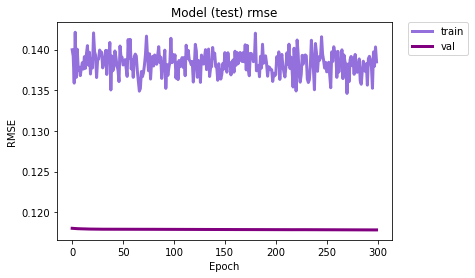

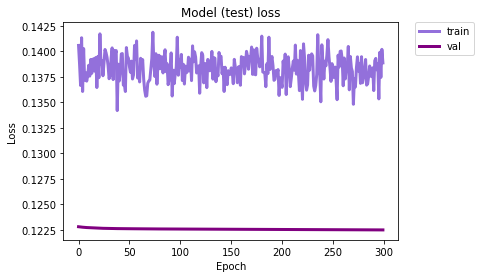

In [16]:
# fitting the model
modelTime = build_model(TIMESTEPS, FEATURES, name = 'test')
modelTime, hist_list, loss_list = compile_and_fit(modelTime, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

yhat 0.2134467
Transformed yhat 22.266403
yhat 0.21467252
Transformed yhat 22.281572
yhat 0.21482155
Transformed yhat 22.283417
yhat 0.21440192
Transformed yhat 22.278225
yhat 0.21372074
Transformed yhat 22.269794
yhat 0.21309304
Transformed yhat 22.262026
yhat 0.2123315
Transformed yhat 22.252604
yhat 0.21173523
Transformed yhat 22.245224
yhat 0.21133374
Transformed yhat 22.240255
yhat 0.21106021
Transformed yhat 22.23687
yhat 0.21067078
Transformed yhat 22.232052
yhat 0.21038032
Transformed yhat 22.228456
Real data: [23.41402715 21.84615385 21.84615385 22.10746606 26.42880917 21.84615385
 24.28088018 27.16572398 28.1300905  21.84615385 21.84615385 21.84615385
 21.84615385 21.84615385 21.84615385 21.84615385 21.84615385 21.84615385
 21.84615385 21.84615385 21.84615385 21.84615385 28.0214497  25.49112426]
Forecasting values: [22.3, 22.3, 22.3, 22.3, 22.3, 22.3, 22.3, 22.2, 22.2, 22.2, 22.2, 22.2]


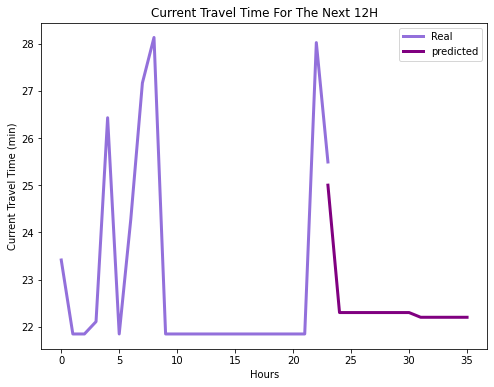

In [17]:
# Recursive Multi-step Forecast
forecasts = forecast(modelTime,normalized_Time, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction(normalized_Time, forecasts, scaler)

In [18]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)
        
#for i in hour:
    #print(i)

In [19]:
import csv

with open('predictionsTime.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.1',forecasts[i],hour[i]
        writer.writerow(d) 

# LSTM - Speed

In [20]:
# our supervised problem
x, y = to_supervised(normalized_Speed, TIMESTEPS, FEATURES)
print('Training shape:', x.shape)
print('Training labels shape:', y.shape)

Training shape: (352, 24, 1)
Training labels shape: (352, 1)


Epoch 1/300
3/3 [==============================] - 4s 432ms/step - loss: 0.7493 - mae: 0.7466 - rmse: 0.7392 - val_loss: 0.6680 - val_mae: 0.6680 - val_rmse: 0.6680
Epoch 2/300
3/3 [==============================] - 0s 62ms/step - loss: 0.7022 - mae: 0.6982 - rmse: 0.6933 - val_loss: 0.6139 - val_mae: 0.6139 - val_rmse: 0.6139
Epoch 3/300
3/3 [==============================] - 0s 60ms/step - loss: 0.6393 - mae: 0.6357 - rmse: 0.6342 - val_loss: 0.5658 - val_mae: 0.5658 - val_rmse: 0.5658
Epoch 4/300
3/3 [==============================] - 0s 63ms/step - loss: 0.5949 - mae: 0.5901 - rmse: 0.5923 - val_loss: 0.5222 - val_mae: 0.5222 - val_rmse: 0.5222
Epoch 5/300
3/3 [==============================] - 0s 57ms/step - loss: 0.5616 - mae: 0.5565 - rmse: 0.5578 - val_loss: 0.4821 - val_mae: 0.4821 - val_rmse: 0.4821
Epoch 6/300
3/3 [==============================] - 0s 57ms/step - loss: 0.5284 - mae: 0.5223 - rmse: 0.5272 - val_loss: 0.4451 - val_mae: 0.4451 - val_rmse: 0.4451
Epoch 7/300
3/3

dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse', 'lr'])


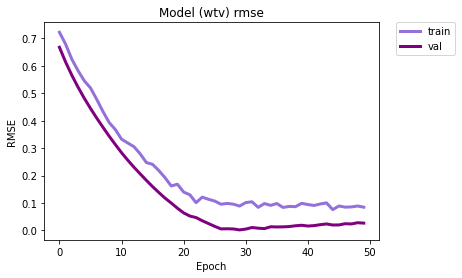

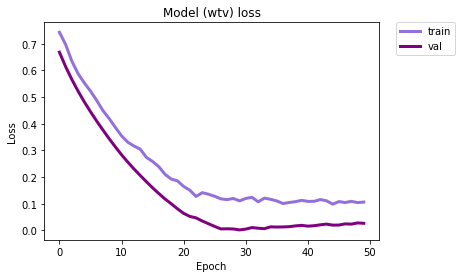

Epoch 1/300
5/5 [==============================] - 0s 58ms/step - loss: 0.0912 - mae: 0.0694 - rmse: 0.0907 - val_loss: 0.0246 - val_mae: 0.0118 - val_rmse: 0.0246
Epoch 2/300
5/5 [==============================] - 0s 46ms/step - loss: 0.0826 - mae: 0.0601 - rmse: 0.0791 - val_loss: 0.0246 - val_mae: 0.0124 - val_rmse: 0.0246
Epoch 3/300
5/5 [==============================] - 0s 47ms/step - loss: 0.0892 - mae: 0.0675 - rmse: 0.0843 - val_loss: 0.0245 - val_mae: 0.0127 - val_rmse: 0.0245
Epoch 4/300
5/5 [==============================] - 0s 46ms/step - loss: 0.0912 - mae: 0.0657 - rmse: 0.0910 - val_loss: 0.0244 - val_mae: 0.0134 - val_rmse: 0.0244
Epoch 5/300
5/5 [==============================] - 0s 50ms/step - loss: 0.0880 - mae: 0.0658 - rmse: 0.0898 - val_loss: 0.0244 - val_mae: 0.0141 - val_rmse: 0.0244
Epoch 6/300
5/5 [==============================] - 0s 61ms/step - loss: 0.0903 - mae: 0.0633 - rmse: 0.0879 - val_loss: 0.0244 - val_mae: 0.0141 - val_rmse: 0.0244
Epoch 7/300
5/5 

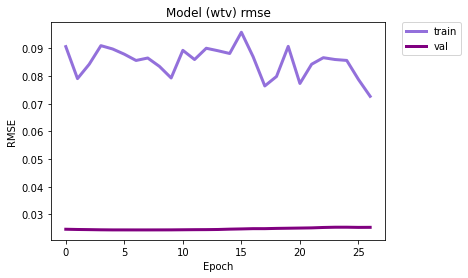

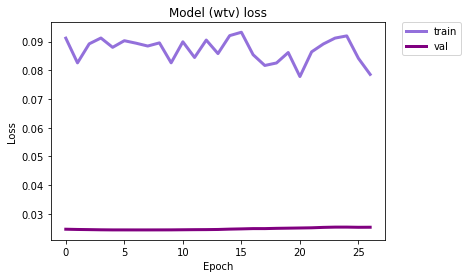

Epoch 1/300
7/7 [==============================] - 0s 58ms/step - loss: 0.0794 - mae: 0.0618 - rmse: 0.0817 - val_loss: 0.0743 - val_mae: 0.0412 - val_rmse: 0.0479
Epoch 2/300
7/7 [==============================] - 0s 50ms/step - loss: 0.0757 - mae: 0.0576 - rmse: 0.0794 - val_loss: 0.0741 - val_mae: 0.0415 - val_rmse: 0.0481
Epoch 3/300
7/7 [==============================] - 0s 47ms/step - loss: 0.0846 - mae: 0.0617 - rmse: 0.0891 - val_loss: 0.0740 - val_mae: 0.0418 - val_rmse: 0.0483
Epoch 4/300
7/7 [==============================] - 0s 46ms/step - loss: 0.0849 - mae: 0.0629 - rmse: 0.0916 - val_loss: 0.0738 - val_mae: 0.0421 - val_rmse: 0.0485
Epoch 5/300
7/7 [==============================] - 0s 46ms/step - loss: 0.0782 - mae: 0.0593 - rmse: 0.0836 - val_loss: 0.0737 - val_mae: 0.0423 - val_rmse: 0.0487
Epoch 6/300
7/7 [==============================] - 0s 68ms/step - loss: 0.0821 - mae: 0.0605 - rmse: 0.0893 - val_loss: 0.0736 - val_mae: 0.0425 - val_rmse: 0.0488
Epoch 7/300
7/7 

Epoch 51/300
7/7 [==============================] - 0s 48ms/step - loss: 0.0781 - mae: 0.0578 - rmse: 0.0852 - val_loss: 0.0718 - val_mae: 0.0474 - val_rmse: 0.0527
Epoch 52/300
7/7 [==============================] - 0s 47ms/step - loss: 0.0811 - mae: 0.0595 - rmse: 0.0872 - val_loss: 0.0718 - val_mae: 0.0474 - val_rmse: 0.0527
Epoch 53/300
7/7 [==============================] - 0s 44ms/step - loss: 0.0811 - mae: 0.0623 - rmse: 0.0878 - val_loss: 0.0718 - val_mae: 0.0475 - val_rmse: 0.0527
Epoch 54/300
7/7 [==============================] - 0s 44ms/step - loss: 0.0867 - mae: 0.0610 - rmse: 0.0945 - val_loss: 0.0718 - val_mae: 0.0475 - val_rmse: 0.0528
Epoch 55/300
7/7 [==============================] - 0s 45ms/step - loss: 0.0790 - mae: 0.0611 - rmse: 0.0847 - val_loss: 0.0718 - val_mae: 0.0474 - val_rmse: 0.0527
Epoch 56/300
7/7 [==============================] - 0s 47ms/step - loss: 0.0805 - mae: 0.0628 - rmse: 0.0870 - val_loss: 0.0718 - val_mae: 0.0474 - val_rmse: 0.0527
Epoch 57/3

Epoch 101/300
7/7 [==============================] - 0s 47ms/step - loss: 0.0802 - mae: 0.0614 - rmse: 0.0864 - val_loss: 0.0716 - val_mae: 0.0482 - val_rmse: 0.0533
Epoch 102/300
7/7 [==============================] - 0s 51ms/step - loss: 0.0767 - mae: 0.0574 - rmse: 0.0828 - val_loss: 0.0716 - val_mae: 0.0482 - val_rmse: 0.0533
Epoch 103/300
7/7 [==============================] - 0s 51ms/step - loss: 0.0793 - mae: 0.0576 - rmse: 0.0853 - val_loss: 0.0716 - val_mae: 0.0482 - val_rmse: 0.0533
Epoch 104/300
7/7 [==============================] - 0s 44ms/step - loss: 0.0767 - mae: 0.0589 - rmse: 0.0818 - val_loss: 0.0716 - val_mae: 0.0482 - val_rmse: 0.0533
Epoch 105/300
7/7 [==============================] - 0s 47ms/step - loss: 0.0765 - mae: 0.0588 - rmse: 0.0813 - val_loss: 0.0716 - val_mae: 0.0482 - val_rmse: 0.0533
Epoch 106/300
7/7 [==============================] - 0s 44ms/step - loss: 0.0794 - mae: 0.0597 - rmse: 0.0846 - val_loss: 0.0717 - val_mae: 0.0480 - val_rmse: 0.0531
Epoc

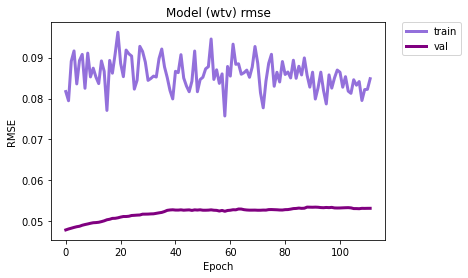

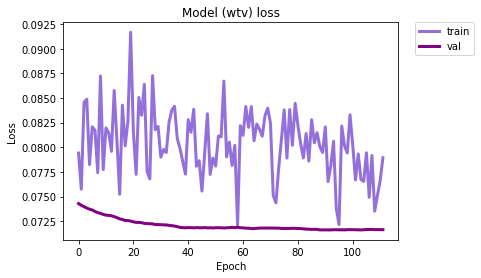

Epoch 1/300
9/9 [==============================] - 0s 51ms/step - loss: 0.0818 - mae: 0.0616 - rmse: 0.0827 - val_loss: 0.0437 - val_mae: 0.0334 - val_rmse: 0.0551
Epoch 2/300
9/9 [==============================] - 0s 45ms/step - loss: 0.0756 - mae: 0.0575 - rmse: 0.0749 - val_loss: 0.0434 - val_mae: 0.0331 - val_rmse: 0.0549
Epoch 3/300
9/9 [==============================] - 0s 43ms/step - loss: 0.0822 - mae: 0.0602 - rmse: 0.0809 - val_loss: 0.0434 - val_mae: 0.0330 - val_rmse: 0.0549
Epoch 4/300
9/9 [==============================] - 0s 43ms/step - loss: 0.0773 - mae: 0.0586 - rmse: 0.0771 - val_loss: 0.0435 - val_mae: 0.0331 - val_rmse: 0.0549
Epoch 5/300
7/9 [======================>.......] - ETA: 0s - loss: 0.0816 - mae: 0.0611 - rmse: 0.0816

In [ ]:
# fitting the model
modelSpeed = build_model(TIMESTEPS, FEATURES, name ='wtv')
modelSpeed , hist_list, loss_list = compile_and_fit(modelSpeed, x, y, EPOCHS, BATCH_SIZE, CV_SPLITS)

In [ ]:
# Recursive Multi-step Forecast
forecastSpeed = forecast(modelSpeed,normalized_Speed, scaler, TIMESTEPS, MULTISTEPS, FEATURES, BATCH_SIZE)

plot_prediction_Speed(normalized_Speed, forecastSpeed, scaler)

In [ ]:
hour = []
ts = traffic.iloc[-1]['timeStamp']
tss = pd.to_datetime(ts).hour

for i in range(12):
    if tss == 23:
        newHour =  ts + pd.DateOffset(hour=0)
        day = pd.to_datetime(ts).day
        newDay = newHour + pd.DateOffset(day=day+1)
        tss = 0
        ts = newDay
        hour.append(newDay)
    else: 
        h = pd.to_datetime(ts).hour
        newHour = ts + pd.DateOffset(hour=h+1)
        tss = tss+1
        ts = newHour
        hour.append(newHour)

In [ ]:
import csv

with open('predictionsSpeed.csv', mode='a') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(12):
        d = 'Cent.1',forecastSpeed[i],hour[i]
        writer.writerow(d)